In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)

In [64]:
df = pd.read_csv('merged_data.csv')
print(df.shape)
df['default'] = df['default'].astype('int32')
df.head()

(50000, 33)


,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,...,2019-07-24,2019-08-10,0,1,1,42,0,0,3,7
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,...,2019-07-24,2019-08-15,0,3,1,96,12,60,5,4
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,...,2019-07-24,2019-08-21,0,2,1,82,24,147,6,58
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,...,2019-07-24,2019-08-09,0,3,0,115,15,87,5,26
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,...,2019-07-24,2019-08-02,0,4,2,120,0,0,5,10


In [65]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [66]:
X['residence_type'].unique(), X['loan_purpose'].unique(), X['loan_type'].unique()

(array(['Owned', 'Mortgage', 'Rented', nan], dtype=object),
 array(['Auto', 'Home', 'Personal', 'Education', 'Personaal'], dtype=object),
 array(['Secured', 'Unsecured'], dtype=object))

<h3 align="center" style="color:blue">Data Cleaning</h3>

### Handle Missing & Duplicate Values

In [67]:
print(df_train.shape, df_test.shape)
df_train.info()

(37500, 33) (12500, 33)
<class 'pandas.core.frame.DataFrame'>
Index: 37500 entries, 12746 to 37784
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      37500 non-null  object 
 1   age                          37500 non-null  int64  
 2   gender                       37500 non-null  object 
 3   marital_status               37500 non-null  object 
 4   employment_status            37500 non-null  object 
 5   income                       37500 non-null  int64  
 6   number_of_dependants         37500 non-null  int64  
 7   residence_type               37453 non-null  object 
 8   years_at_current_address     37500 non-null  int64  
 9   city                         37500 non-null  object 
 10  state                        37500 non-null  object 
 11  zipcode                      37500 non-null  int64  
 12  loan_id                      37500 non-null  object

In [68]:
df_train.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 47
years_at_current_address        0
city                            0
state                           0
zipcode                         0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_at_application     0
disbursal_date                  0
installment_start_dt            0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd     

In [69]:
print(df_train['residence_type'].unique())
mode_resid = df_train['residence_type'].mode()[0]
mode_resid

['Owned' 'Mortgage' 'Rented' nan]


'Owned'

In [70]:
df_train['residence_type'] = df_train['residence_type'].fillna(mode_resid)
df_test['residence_type'] = df_test['residence_type'].fillna(mode_resid)

df_train['residence_type'].unique(), df_test['residence_type'].unique()

(array(['Owned', 'Mortgage', 'Rented'], dtype=object),
 array(['Owned', 'Mortgage', 'Rented'], dtype=object))

In [71]:
columns_continuous = ['age', 'income', 'number_of_dependants', 'years_at_current_address', 
                      'sanction_amount', 'loan_amount', 'processing_fee', 'gst', 'net_disbursement', 
                      'loan_tenure_months','principal_outstanding', 'bank_balance_at_application',
                      'number_of_open_accounts','number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
                       'total_dpd', 'enquiry_count', 'credit_utilization_ratio']

columns_categorical = ['gender', 'marital_status', 'employment_status', 'residence_type', 'city', 
                       'state', 'zipcode', 'loan_purpose', 'loan_type', 'default']

### Box plot to visualize outliers

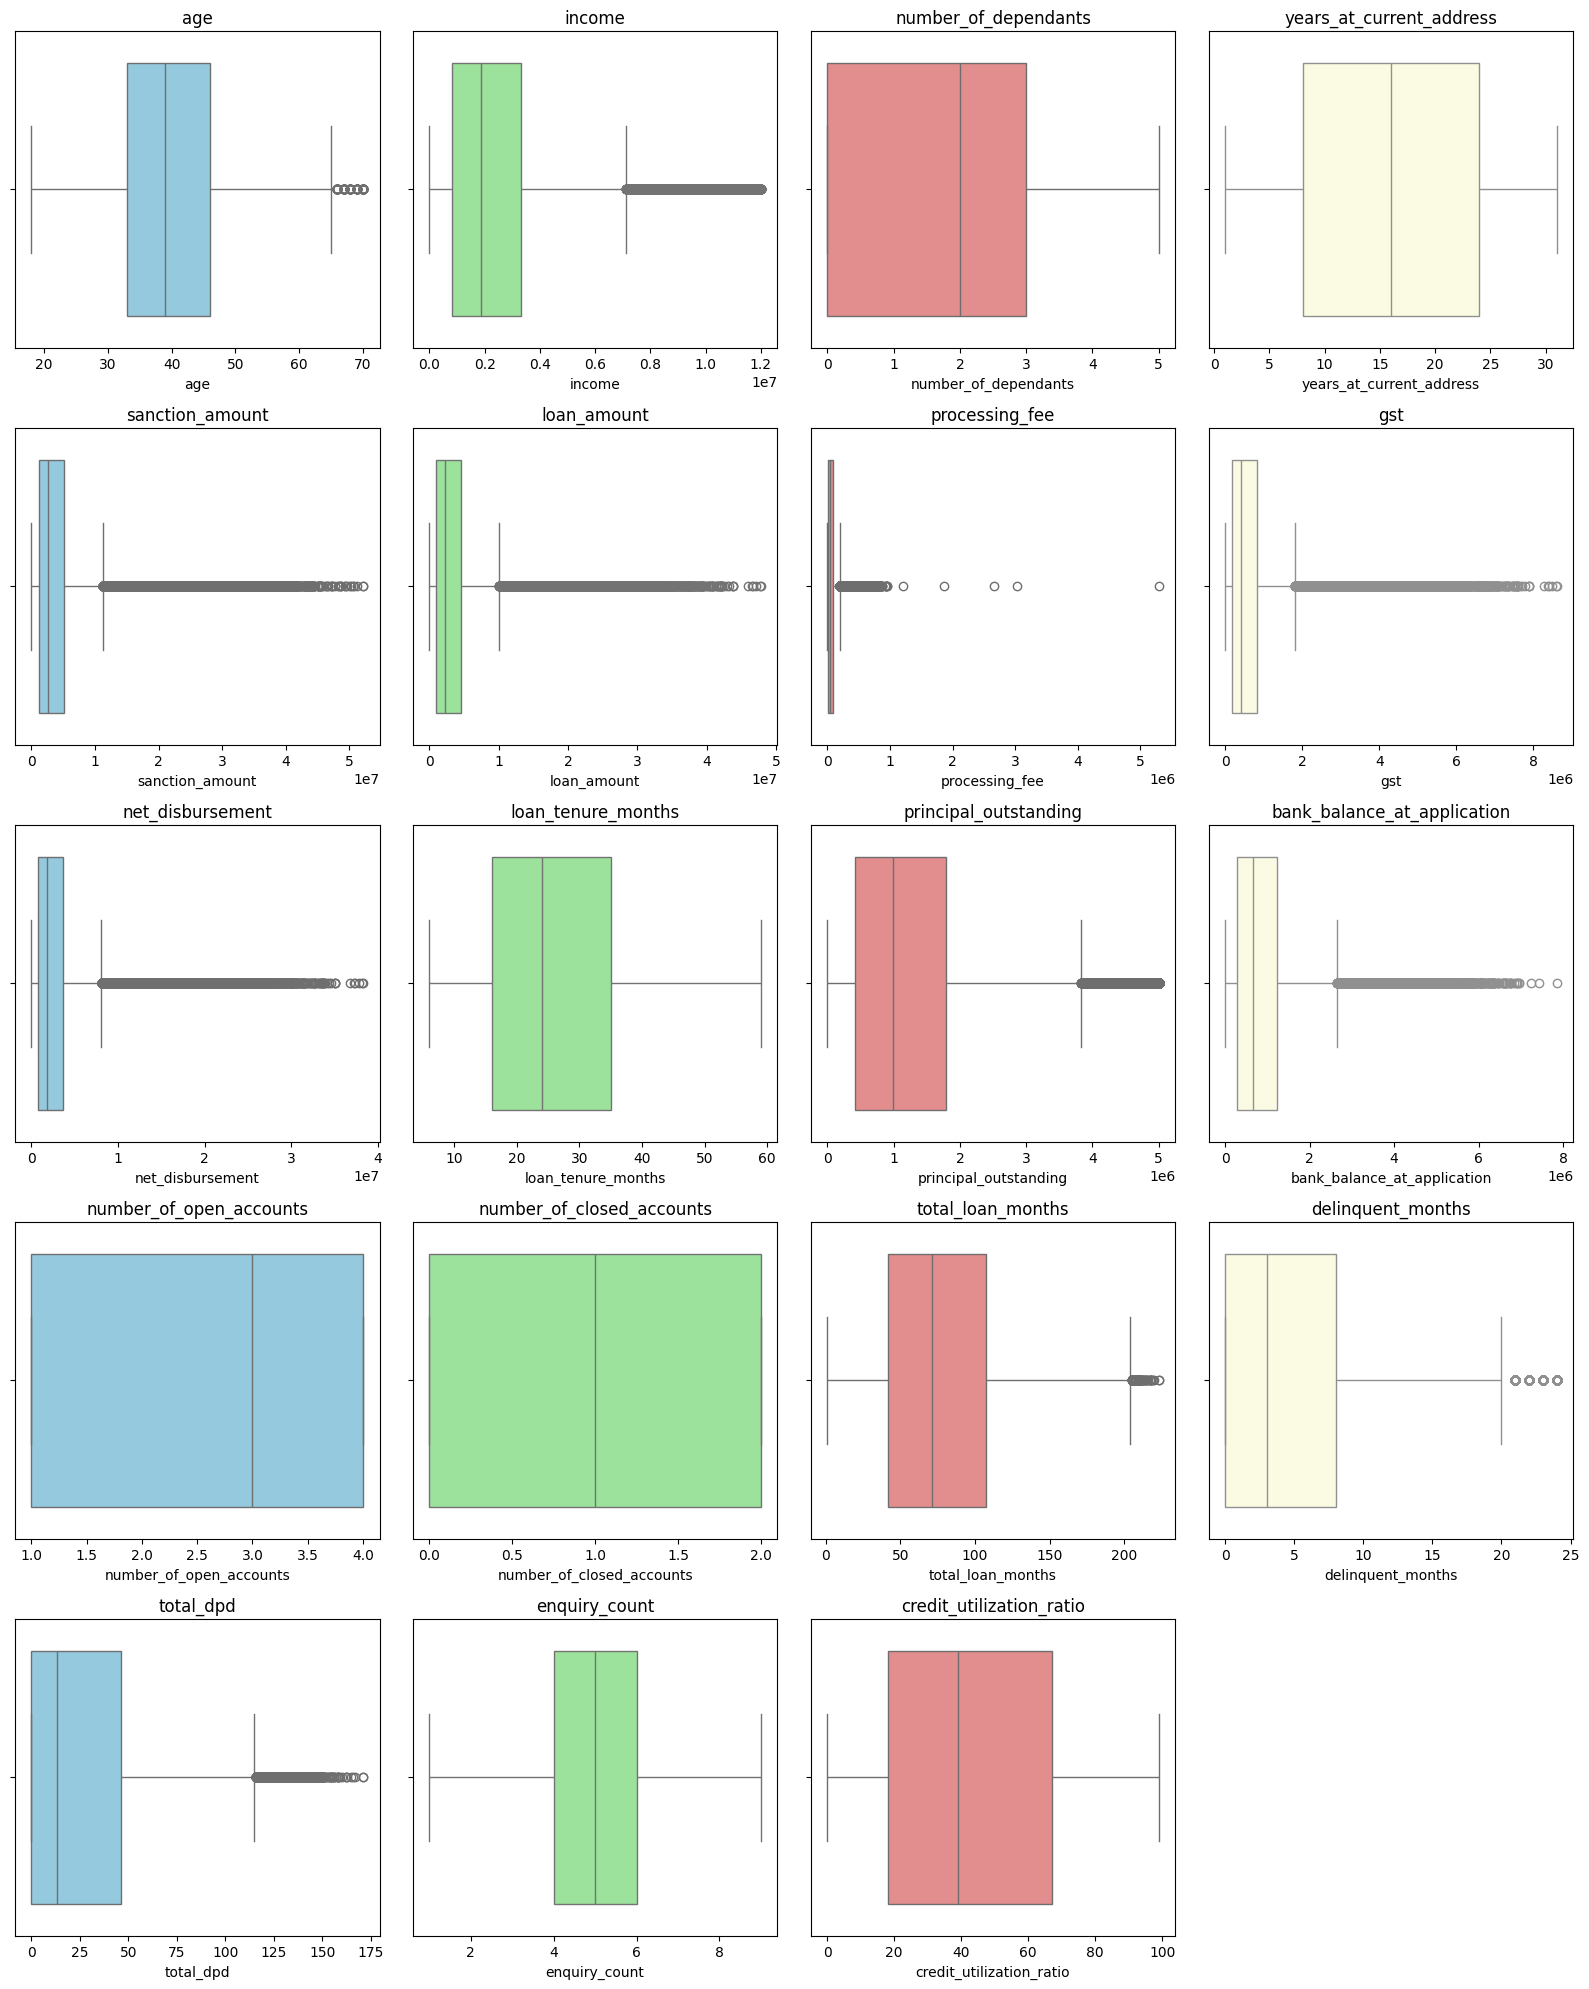

In [72]:
# List of colors you want to use for each boxplot
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']

# Calculate the number of rows needed based on the number of continuous columns
num_columns = len(columns_continuous)
num_rows = (num_columns + 3) // 4  # This ensures there are 4 columns per row

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and plot the boxplot with a different color
for i, col in enumerate(columns_continuous):
    # Cycle through the colors list (in case you have more columns than colors)
    sns.boxplot(data=df_train, x=col, ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(col)

# Remove any unused axes (if there are more axes than columns)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

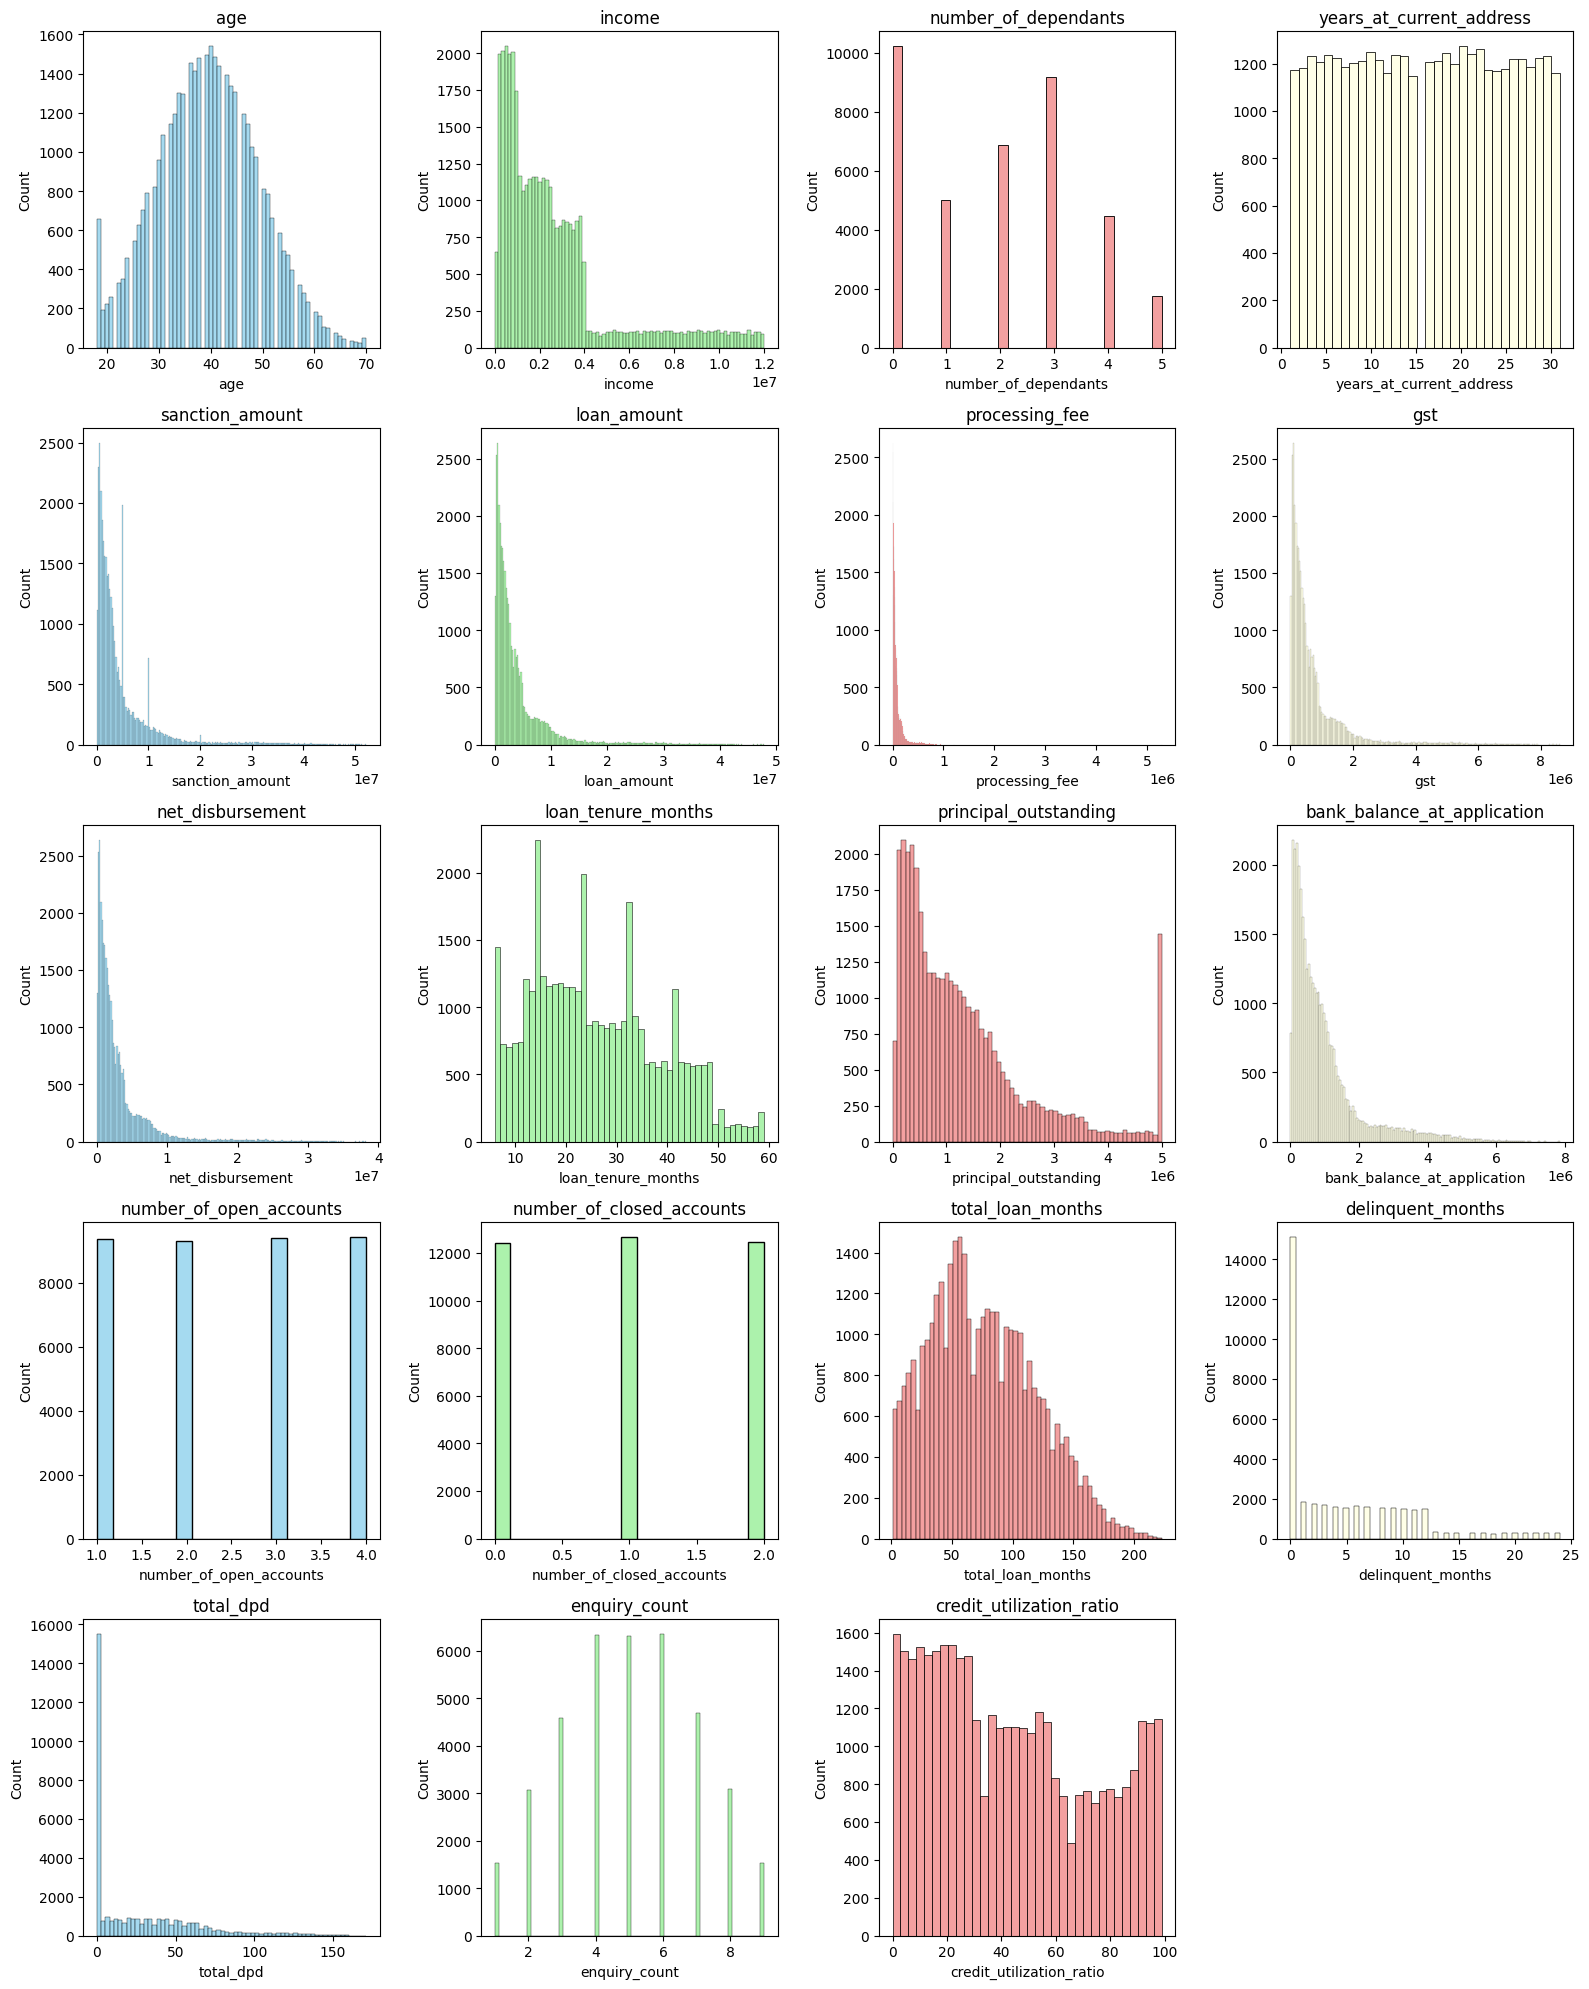

In [73]:
# List of colors you want to use for each boxplot
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']

# Calculate the number of rows needed based on the number of continuous columns
num_columns = len(columns_continuous)
num_rows = (num_columns + 3) // 4  # This ensures there are 4 columns per row

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and plot the boxplot with a different color
for i, col in enumerate(columns_continuous):
    # Cycle through the colors list (in case you have more columns than colors)
    sns.histplot(data=df_train, x=col, ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(col)

# Remove any unused axes (if there are more axes than columns)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Outlier Removal: Processing Fee

In [74]:
df_train[(df_train['processing_fee'] / df_train['loan_amount']) > 0.03][['loan_amount','processing_fee']]

,loan_amount,processing_fee
23981,2234000,2669791.02
28174,966000,1214492.67
47089,1738000,1858964.77
29305,2616000,3036378.01
9898,3626000,5293543.52


In [75]:
df_train1 = df_train[(df_train['processing_fee'] / df_train['loan_amount']) < 0.03].copy()
df_train1[(df_train1['processing_fee'] / df_train1['loan_amount']) > 0.03]

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default


In [76]:
df_test = df_test[(df_test['processing_fee'] / df_test['loan_amount']) < 0.03].copy()
df_test[(df_test['processing_fee'] / df_test['loan_amount']) > 0.03]

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default


In [77]:
print(df_train1[(df_train1['gst']/df_train1['loan_amount']) > 0.2].shape)
print(df_test[(df_test['gst']/df_test['loan_amount']) > 0.2].shape)

(0, 33)
(0, 33)


In [78]:
print(df_train1[df_train1['net_disbursement'] > df_train1['loan_amount']].shape)
print(df_test[df_test['net_disbursement'] > df_test['loan_amount']].shape)

(0, 33)
(0, 33)


In [79]:
print(df_train1[df_train1['net_disbursement'] > df_train1['sanction_amount']].shape)
print(df_test[df_test['net_disbursement'] > df_test['sanction_amount']].shape)

(0, 33)
(0, 33)


### Analyze Categorical Columns

In [80]:
for col in columns_categorical:
	print(col, '-->' ,df_train1[col].unique())

gender --> ['M' 'F']
marital_status --> ['Married' 'Single']
employment_status --> ['Self-Employed' 'Salaried']
residence_type --> ['Owned' 'Mortgage' 'Rented']
city --> ['Hyderabad' 'Mumbai' 'Chennai' 'Bangalore' 'Pune' 'Kolkata' 'Ahmedabad'
 'Delhi' 'Lucknow' 'Jaipur']
state --> ['Telangana' 'Maharashtra' 'Tamil Nadu' 'Karnataka' 'West Bengal'
 'Gujarat' 'Delhi' 'Uttar Pradesh' 'Rajasthan']
zipcode --> [500001 400001 600001 560001 411001 700001 380001 110001 226001 302001]
loan_purpose --> ['Home' 'Education' 'Personal' 'Auto' 'Personaal']
loan_type --> ['Secured' 'Unsecured']
default --> [0 1]


### Fix Errors in Loan Purpose Column

In [81]:
df_train1['loan_purpose'] = df_train1['loan_purpose'].replace('Personaal','Personal')
df_train1['loan_purpose'].unique()

array(['Home', 'Education', 'Personal', 'Auto'], dtype=object)

In [82]:
df_test['loan_purpose'] = df_test['loan_purpose'].replace('Personaal','Personal')
df_test['loan_purpose'].unique()

array(['Home', 'Education', 'Auto', 'Personal'], dtype=object)

<h3 style="color:blue" align="center">Exploratory Data Analysis</h3>

In [83]:
columns_continuous

['age',
 'income',
 'number_of_dependants',
 'years_at_current_address',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio']

### Age Column

In [84]:
df_train1.groupby('default')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,34265.00,39.77,9.88,18.00,33.00,40.00,46.00,70.00
1,3223.00,37.12,9.29,18.00,31.00,37.00,44.00,70.00


**Insights**

1. Average age in the default group is little less (37.12) than the average (39.7) of the group that did not default
1. Variability (standard deviation) is mostly similar in both the groups
1. Both the groups have similar min and max ages

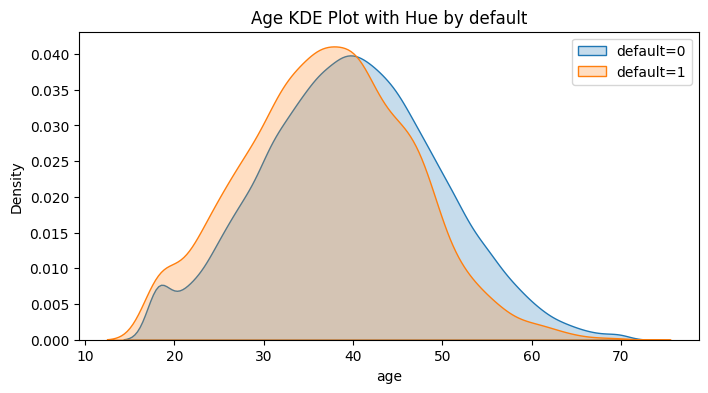

In [85]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train1['age'][df_train1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train1['age'][df_train1['default'] == 1], fill=True, label='default=1')
plt.title(f"Age KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. Orange (defaulted) group is slightly shifted to left indicating that younger folks are more likely to default on their loans

### KDE for all the Columns

In [1]:
plt.figure(figsize=(24, 20))  # Width, height in inches

for i, col in enumerate(columns_continuous):
    plt.subplot(6, 4, i+1)  # 1 row, 4 columns, ith subplot
    sns.kdeplot(df_train1[col][df_train1['default']==0], fill=True, label='default=0')
    sns.kdeplot(df_train1[col][df_train1['default']==1], fill=True, label='default=1')
    plt.title(col)        
    plt.xlabel('')
    
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

**Insights**

1. In columns: loan_tenure_months, delinquent_months, total_dpd, credit_utilization, higher values indicate high likelyhood of becoming a default. Hence these 4 looks like strong predictors
1. In remaining columns the distributions do not give any obvious insights
1. Why loan_amount and income did not give any signs of being strong predictors? May be when we combine these two and get loan to income ratio (LTI), that may have influence on the target variable. We will explore more later

<h3 style="color:blue" align="center">Feature Engineering, Feature Selection</h3>

In [87]:
columns_continuous

['age',
 'income',
 'number_of_dependants',
 'years_at_current_address',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio']

#### Generate Loan to Income (LTI) Ratio

In [88]:
df_train1['loan_to_income'] = df_train1['loan_amount'] / df_train1['income']
df_test['loan_to_income'] = df_test['loan_amount'] / df_test['income']

df_train1[['loan_to_income','loan_amount','income']].sample(5)

,loan_to_income,loan_amount,income
7838,2.60,2028000,781000
35074,1.55,3591000,2310000
394,2.28,8896000,3900000
5351,0.75,3972000,5303000
20933,2.69,2226000,828000


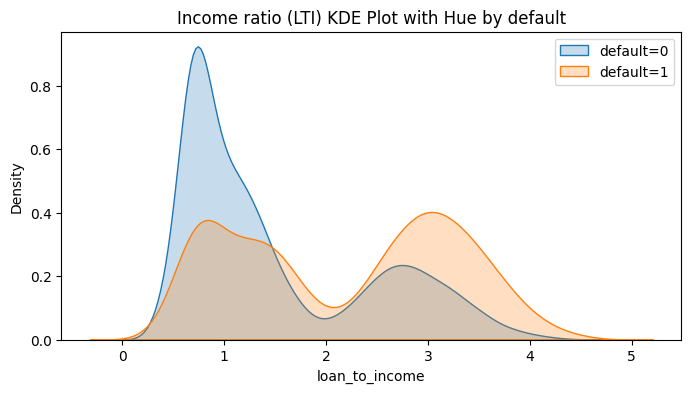

In [89]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train1['loan_to_income'][df_train1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train1['loan_to_income'][df_train1['default'] == 1], fill=True, label='default=1')
plt.title(f"Income ratio (LTI) KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. Blue graph has majority of its values on lower side of LTI
2. Orange graph has many values when LTI is higher indicating that higher LTI means high risk loan

#### Generate Delinquency Ratio

In [90]:
df_train1['delinquent_ratio'] = (df_train1['delinquent_months']*100 / df_train1['total_loan_months'])
df_test['delinquent_ratio'] = (df_test['delinquent_months']*100 / df_test['total_loan_months'])

df_train1[['delinquent_ratio','delinquent_months','total_loan_months']].sample(5)

,delinquent_ratio,delinquent_months,total_loan_months
35988,21.43,15,70
43008,0.00,0,101
39325,11.54,9,78
31381,7.59,11,145
3329,0.00,0,37


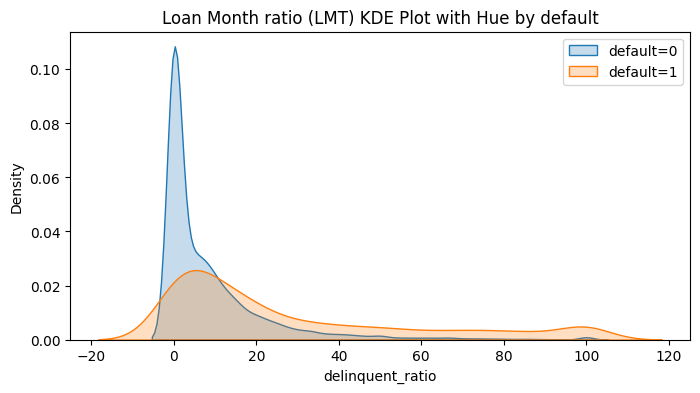

In [91]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train1['delinquent_ratio'][df_train1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train1['delinquent_ratio'][df_train1['default'] == 1], fill=True, label='default=1')
plt.title(f"Loan Month ratio (LMT) KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. Blue graph has majority of its values on lower side of LTI
2. Orange graph has many values when delinquency ratio is higher indicating some correlation on default

#### Generate Avg DPD Per Delinquency

In [92]:
df_train1['avg_dpd_per_deliquency'] = np.where(
	df_train1['delinquent_months'] != 0,
	df_train1['total_dpd'] / df_train1['delinquent_months'], 0
)

df_test['avg_dpd_per_deliquency'] = np.where(
	df_test['delinquent_months'] != 0,
	df_test['total_dpd'] / df_test['delinquent_months'], 0
)

df_train1['avg_dpd_per_deliquency'].describe()

count   37488.00
mean        3.28
std         2.91
min         0.00
25%         0.00
50%         4.33
75%         5.74
max        10.00
Name: avg_dpd_per_deliquency, dtype: float64

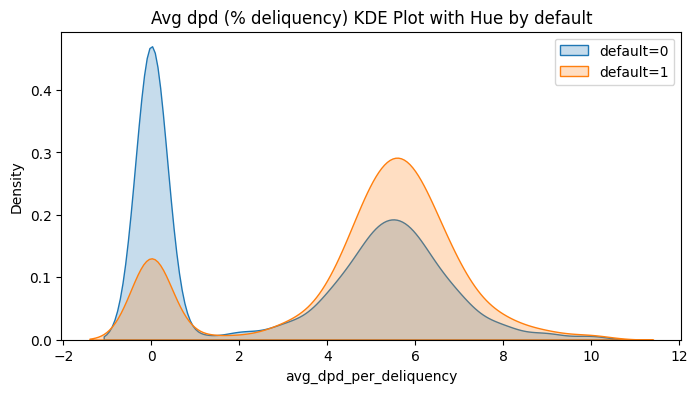

In [93]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train1['avg_dpd_per_deliquency'][df_train1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train1['avg_dpd_per_deliquency'][df_train1['default'] == 1], fill=True, label='default=1')
plt.title(f"Avg dpd (% deliquency) KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. Graph clearly shows more occurances of default cases when avg_dpd_per_delinquency is high. This means this column is a strong predictor

### Remove columns that are just unique ids and don't have influence on target

In [94]:
df_train1.columns ,df_test.columns


(Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
        'income', 'number_of_dependants', 'residence_type',
        'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
        'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
        'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
        'principal_outstanding', 'bank_balance_at_application',
        'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
        'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
        'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default',
        'loan_to_income', 'delinquent_ratio', 'avg_dpd_per_deliquency'],
       dtype='object'),
 Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
        'income', 'number_of_dependants', 'residence_type',
        'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
        'loan_purpose', 'loan_type', 'sa

In [95]:
df_train2 = df_train1.drop(['cust_id','loan_id'], axis=1)
df_test = df_test.drop(['cust_id','loan_id'], axis=1)

df_train2.columns

Index(['age', 'gender', 'marital_status', 'employment_status', 'income',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'sanction_amount', 'loan_amount', 'processing_fee', 'gst',
       'net_disbursement', 'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'disbursal_date', 'installment_start_dt',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'total_loan_months', 'delinquent_months', 'total_dpd', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquent_ratio', 'avg_dpd_per_deliquency'],
      dtype='object')

### Remove columns that business contact person asked us to remove

In [96]:
df_train3 = df_train2.drop(['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 
                              'total_loan_months', 'delinquent_months', 'total_dpd'], axis="columns")
df_test = df_test.drop(['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 
                              'total_loan_months', 'delinquent_months', 'total_dpd'], axis="columns")
df_train3.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquent_ratio', 'avg_dpd_per_deliquency'],
      dtype='object')

In [97]:
numeric_col = df_train3.select_dtypes(['int64','float64']).columns
numeric_col

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquent_ratio',
       'avg_dpd_per_deliquency'],
      dtype='object')

In [98]:
X_train = df_train3.drop('default',axis=1)
y_train = df_train3['default']

scaler = MinMaxScaler()
X_train[numeric_col] = scaler.fit_transform(X_train[numeric_col])

X_train.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquent_ratio,avg_dpd_per_deliquency
count,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00
mean,0.41,0.39,0.50,0.52,0.09,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.10,0.33
std,0.19,0.31,0.30,0.29,0.12,0.11,0.11,0.11,0.23,0.24,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.40,0.40,0.50,0.49,0.05,0.05,0.05,0.05,0.34,0.19,0.08,0.67,0.50,0.50,0.39,0.20,0.04,0.43
75%,0.54,0.60,0.77,0.76,0.10,0.10,0.10,0.10,0.55,0.35,0.16,1.00,1.00,0.62,0.68,0.51,0.13,0.57
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [99]:
X_test = df_test.drop('default', axis=1)
y_test = df_test['default']

X_test[numeric_col] = scaler.transform(X_test[numeric_col])
X_test.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquent_ratio,avg_dpd_per_deliquency
count,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00
mean,0.42,0.38,0.50,0.53,0.09,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.11,0.33
std,0.19,0.31,0.30,0.29,0.12,0.11,0.11,0.11,0.23,0.25,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.42,0.40,0.50,0.51,0.05,0.05,0.05,0.05,0.34,0.20,0.08,0.33,0.50,0.50,0.39,0.20,0.04,0.44
75%,0.54,0.60,0.77,0.76,0.10,0.09,0.09,0.09,0.55,0.36,0.16,0.67,1.00,0.62,0.68,0.50,0.13,0.58
max,1.00,1.00,1.00,1.00,0.98,0.96,0.96,0.96,1.00,1.00,0.94,1.00,1.00,1.00,1.00,1.01,1.00,1.00


### VIF to measure multicolinearity

In [100]:

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X_train[numeric_col])

,Column,VIF
0,age,5.70
1,number_of_dependants,2.73
2,years_at_current_address,3.42
3,zipcode,3.80
4,sanction_amount,101.09
5,processing_fee,inf
6,gst,inf
7,net_disbursement,inf
8,loan_tenure_months,6.18
9,principal_outstanding,16.33


In [101]:
features_to_drop_vif = ['sanction_amount', 'processing_fee', 'gst', 'net_disbursement','principal_outstanding']


X_train1 = X_train.drop(features_to_drop_vif, axis='columns')
numeric_columns = X_train1.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquent_ratio',
       'avg_dpd_per_deliquency'],
      dtype='object')

In [102]:
vif_df = calculate_vif(X_train1[numeric_columns])
vif_df

,Column,VIF
0,age,5.43
1,number_of_dependants,2.73
2,years_at_current_address,3.40
3,zipcode,3.78
4,loan_tenure_months,6.02
5,bank_balance_at_application,1.80
6,number_of_open_accounts,4.35
7,number_of_closed_accounts,2.37
8,enquiry_count,6.38
9,credit_utilization_ratio,2.92


In [103]:
selected_numeric_features_vif = vif_df.Column.values
selected_numeric_features_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquent_ratio', 'avg_dpd_per_deliquency'], dtype=object)

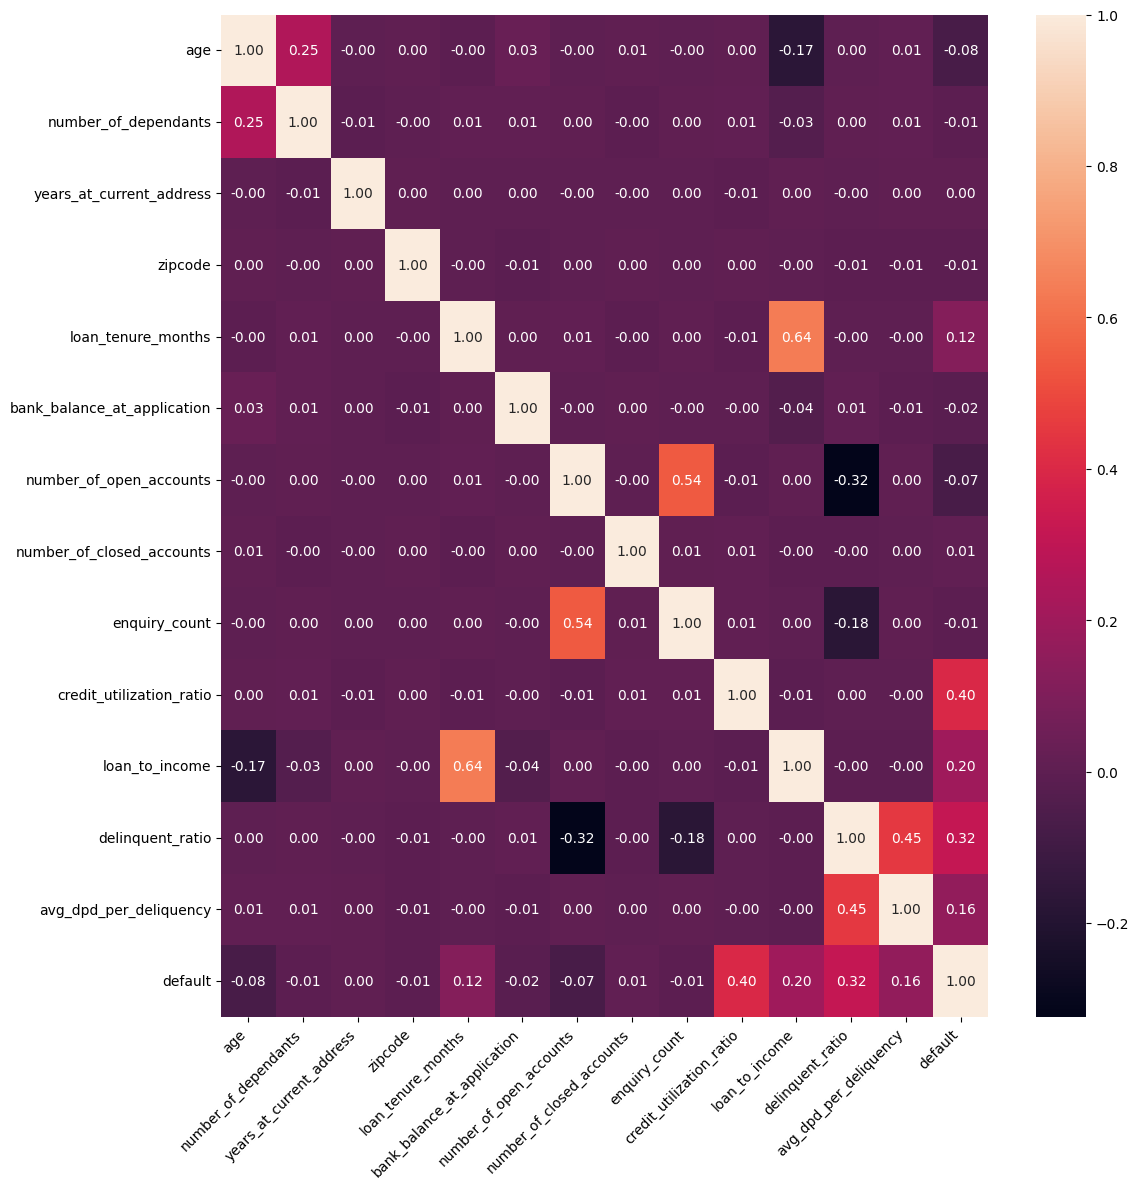

In [104]:
plt.figure(figsize=(12,12))
cm = df_train3[numeric_columns.append(pd.Index(['default']))].corr()
sns.heatmap(cm, annot=True, fmt='0.2f')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Feature Selection: Categorical Features

In [105]:
columns_categorical

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

In [106]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count','sum'])
    grouped = grouped.rename(columns={'count': 'total', 'sum': 'good'})
    grouped['bad']=grouped['total']-grouped['good']
    
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad
    grouped['woe'] = np.log(grouped['good_pct']/ grouped['bad_pct'])
    grouped['iv'] = (grouped['good_pct'] -grouped['bad_pct'])*grouped['woe']
    
    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf], 0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf], 0)
    
    total_iv = grouped['iv'].sum()
    
    return grouped, total_iv

grouped, total_iv = calculate_woe_iv(pd.concat([X_train1, y_train],axis=1), 'loan_purpose', 'default')
grouped

,total,good,bad,good_pct,bad_pct,woe,iv
loan_purpose,,,,,,,
Auto,7447,327,7120,0.10,0.21,-0.72,0.08
Education,5620,559,5061,0.17,0.15,0.16,0.00
Home,11304,1734,9570,0.54,0.28,0.66,0.17
Personal,13117,603,12514,0.19,0.37,-0.67,0.12


In [107]:
iv_value = {}

for col in X_train1.columns:
    if X_train1[col].dtype == 'object':
        _, iv = calculate_woe_iv(pd.concat([X_train1, y_train],axis=1), col, 'default')
    else:
        X_binned = pd.cut(X_train1[col], bins=10, labels=False)
        _, iv = calculate_woe_iv(pd.concat([X_binned, y_train],axis=1), col, 'default' )
    iv_value[col] = iv
iv_value

{'age': np.float64(0.0890689462679479),
 'gender': np.float64(0.00047449502170914947),
 'marital_status': np.float64(0.001129766845390142),
 'employment_status': np.float64(0.003953046301722585),
 'number_of_dependants': np.float64(0.0019380899135053508),
 'residence_type': np.float64(0.246745268718145),
 'years_at_current_address': np.float64(0.0020800513608156363),
 'city': np.float64(0.0019059578709781529),
 'state': np.float64(0.0019005589806779287),
 'zipcode': np.float64(0.0016677413243392572),
 'loan_purpose': np.float64(0.3691197842282755),
 'loan_type': np.float64(0.16319324904149224),
 'loan_tenure_months': np.float64(0.21893515090196278),
 'bank_balance_at_application': np.float64(0.0063187993277516365),
 'number_of_open_accounts': np.float64(0.08463134083005877),
 'number_of_closed_accounts': np.float64(0.0011964272592421567),
 'enquiry_count': np.float64(0.007864214085342608),
 'credit_utilization_ratio': np.float64(2.352965568168245),
 'loan_to_income': np.float64(0.47572

In [108]:
iv_df = pd.DataFrame(list(iv_value.items()), columns=['Feature', 'IV'])
iv_df = iv_df.sort_values(by='IV', ascending=False)
iv_df

,Feature,IV
17,credit_utilization_ratio,2.35
19,delinquent_ratio,0.72
18,loan_to_income,0.48
20,avg_dpd_per_deliquency,0.40
10,loan_purpose,0.37
5,residence_type,0.25
12,loan_tenure_months,0.22
11,loan_type,0.16
0,age,0.09
14,number_of_open_accounts,0.08


In [109]:
# select features that has IV > 0.02
selected_features_iv = [feature for feature, iv in iv_value.items() if iv > 0.02]
selected_features_iv

['age',
 'residence_type',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_to_income',
 'delinquent_ratio',
 'avg_dpd_per_deliquency']

### Feature Encoding

In [110]:
print(X_train1[selected_features_iv].shape, X_test[selected_features_iv].shape)
X_train_reduced = X_train1[selected_features_iv]
X_test_reduced = X_test[selected_features_iv]

(37488, 10) (12497, 10)


In [111]:
X_train_encoded = pd.get_dummies(X_train_reduced, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_reduced, drop_first=True)

X_train_encoded.head()

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquent_ratio,avg_dpd_per_deliquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
12746,0.79,0.42,1.00,0.36,0.42,0.13,0.59,True,False,False,True,False,False
32495,0.50,0.83,0.67,0.05,0.31,0.06,0.62,True,False,True,False,False,False
43675,0.38,0.49,0.00,0.00,0.76,0.22,0.56,False,False,False,True,False,False
9040,0.46,0.64,0.67,0.88,0.19,0.00,0.00,False,False,True,False,False,False
13077,0.77,0.17,0.00,0.72,0.05,0.00,0.00,True,False,False,False,True,True


In [112]:
X_test_encoded.head()

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquent_ratio,avg_dpd_per_deliquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.35,0.75,0.33,0.99,0.55,0.00,0.00,True,False,False,True,False,False
15514,0.48,0.23,1.00,0.32,0.22,0.00,0.00,True,False,True,False,False,False
30367,0.23,0.55,0.67,0.83,0.18,0.00,0.00,True,False,False,False,False,False
35347,0.37,0.75,1.00,0.48,0.57,0.02,0.70,True,False,False,True,False,False
41814,0.58,0.72,0.67,0.98,0.41,0.11,0.64,False,False,False,True,False,False


<h3 align="center" style="color:blue">Model Training</h3>

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

### Attempt 1

1. Logistic Regression, RandomForest & XGB
1. No handling of class imbalance

In [114]:
lr = LogisticRegression()
lr.fit(X_train_encoded, y_train)

y_pred = lr.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.72      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



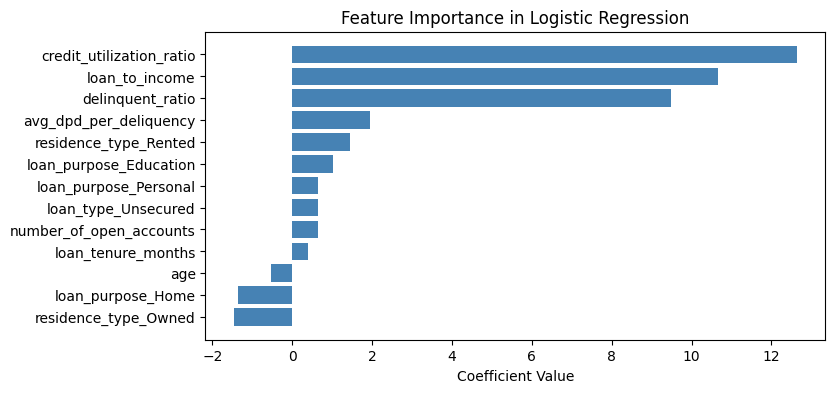

In [115]:
feature_importance = lr.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [116]:
rf = RandomForestClassifier()
rf.fit(X_train_encoded, y_train)
y_predrf = rf.predict(X_test_encoded)
print(classification_report(y_predrf, y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11602
           1       0.72      0.86      0.78       895

    accuracy                           0.97     12497
   macro avg       0.85      0.92      0.88     12497
weighted avg       0.97      0.97      0.97     12497



In [117]:
xgc = XGBClassifier()
xgc.fit(X_train_encoded, y_train)
y_predxg = xgc.predict(X_test_encoded)
print(classification_report(y_test, y_predxg))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.82      0.75      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.87      0.88     12497
weighted avg       0.96      0.96      0.96     12497



Since there is not much difference between XGB and Logistic, we will choose LogisticRegression as a candidate for our RandomizedSearchCV candidate it has a better interpretation.

#### RandomizedSearch CV for Attempt 1: Logistic Regression

In [118]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'solver': 'lbfgs', 'C': np.float64(545.5594781168514)}
Best Score: 0.7571424666678884
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.83      0.74      0.78      1074

    accuracy                           0.97     12497
   macro avg       0.91      0.86      0.88     12497
weighted avg       0.96      0.97      0.96     12497



#### RandomizedSearch CV for Attempt 1: XGBoost

In [119]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # L2 regularization term
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best Score: 0.7881930485302191
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.76      0.83      0.79      1074

    accuracy                           0.96     12497
   macro avg       0.87      0.90      0.89     12497
weighted avg       0.96      0.96      0.96     12497



### Attempt 2

1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

In [120]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_encoded, y_train)
y_train_res.value_counts()

default
0    3223
1    3223
Name: count, dtype: int64

In [121]:
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)

y_pred = lr.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.51      0.96      0.67      1074

    accuracy                           0.92     12497
   macro avg       0.75      0.93      0.81     12497
weighted avg       0.95      0.92      0.93     12497



In [122]:
xgc = XGBClassifier(**random_search.best_params_)
xgc.fit(X_train_res, y_train_res)

y_pred = xgc.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.51      0.98      0.67      1074

    accuracy                           0.92     12497
   macro avg       0.75      0.95      0.81     12497
weighted avg       0.96      0.92      0.93     12497



### Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [123]:
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)
y_train_smt.value_counts()

default
0    34197
1    34197
Name: count, dtype: int64

In [124]:
lr = LogisticRegression()
lr.fit(X_train_smt, y_train_smt)

y_pred = lr.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.55      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.77      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



### Use optuna

In [125]:
import optuna
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score

In [126]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),  # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }

    model = LogisticRegression(**param, max_iter=10000)
    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective, n_trials=50)

[I 2025-06-12 12:04:01,989] A new study created in memory with name: no-name-4b9cd1b3-6f3a-4251-9bdb-591ec9022d27
[I 2025-06-12 12:04:02,152] Trial 0 finished with value: 0.9455654692915266 and parameters: {'C': 140.8160568277, 'solver': 'saga', 'tol': 0.00020067358328077075, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9455654692915266.
[I 2025-06-12 12:04:02,296] Trial 1 finished with value: 0.9456679905374391 and parameters: {'C': 2367.931186032249, 'solver': 'saga', 'tol': 0.0006796006668192714, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9456679905374391.
[I 2025-06-12 12:04:02,459] Trial 2 finished with value: 0.9174739829904538 and parameters: {'C': 0.002528020761984679, 'solver': 'saga', 'tol': 0.00015620472636768603, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9456679905374391.
[I 2025-06-12 12:04:02,570] Trial 3 finished with value: 0.94570799134793 and parameters: {'C': 70.69430223981817, 'solver': 'liblinear', 'tol': 0.01188941718

In [127]:
print('Best trial:')
trial = study_logistic.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_model_logistic = LogisticRegression(**study_logistic.best_params)
best_model_logistic.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9464319888973503
  Params: 
    C: 8731.364098803755
    solver: saga
    tol: 0.029900737223642483
    class_weight: None
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



### Attempt 4

1. XGBoost
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [128]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    param_dist = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),  # Number of trees
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),  # Learning rate
        "max_depth": trial.suggest_int("max_depth", 3, 15),  # Max depth of each tree
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of samples for training
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features per tree
        "gamma": trial.suggest_float("gamma", 0, 5),  # Regularization term
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),  # L2 regularization
        "random_state": 42  # Ensures reproducibility
    }

    # Create the XGBoost model with suggested hyperparameters using **param_dist
    model = XGBClassifier(**param_dist)

    # F1 scorer for evaluation
    f1_scorer = make_scorer(f1_score, average='macro')

    # Evaluate the model: cross-validation with F1 score
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)

    return np.mean(scores)  # Return the mean F1 score

# Create a study object and specify the optimization direction
study_xgboost = optuna.create_study(direction='maximize')

# Perform the optimization
study_xgboost.optimize(objective, n_trials=50)


[I 2025-06-12 12:04:07,268] A new study created in memory with name: no-name-c3282ed8-d78f-4425-b40b-2d5fb2f283aa
[I 2025-06-12 12:04:10,140] Trial 0 finished with value: 0.9723878725155478 and parameters: {'n_estimators': 829, 'learning_rate': 0.1683479393530094, 'max_depth': 3, 'subsample': 0.8541158744387121, 'colsample_bytree': 0.5676794902242046, 'gamma': 0.16903093628061472, 'reg_alpha': 0.34851252703683633, 'reg_lambda': 0.8066877820071916}. Best is trial 0 with value: 0.9723878725155478.
[I 2025-06-12 12:04:11,367] Trial 1 finished with value: 0.9728855099828234 and parameters: {'n_estimators': 128, 'learning_rate': 0.0377742150392398, 'max_depth': 14, 'subsample': 0.8916713939559169, 'colsample_bytree': 0.6118969968173653, 'gamma': 2.558172433850667, 'reg_alpha': 0.2426272731505421, 'reg_lambda': 0.0037417809047305406}. Best is trial 1 with value: 0.9728855099828234.
[I 2025-06-12 12:04:12,312] Trial 2 finished with value: 0.9645248007666619 and parameters: {'n_estimators': 16

In [129]:
print('Best trial:')
trial = study_xgboost.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_params = study_xgboost.best_params
best_model_xgb = XGBClassifier(**best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9796589920701408
  Params: 
    n_estimators: 625
    learning_rate: 0.0784861074181507
    max_depth: 13
    subsample: 0.9753178597858212
    colsample_bytree: 0.7314040014264831
    gamma: 0.014178393008722557
    reg_alpha: 0.6213211832443785
    reg_lambda: 0.6412205945415608
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11423
           1       0.75      0.82      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.87      0.90      0.88     12497
weighted avg       0.96      0.96      0.96     12497



## Model Evaluation : ROC/AUC

In [130]:
from sklearn.metrics import roc_curve, auc

In [131]:
y_pred = best_model_logistic.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [132]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fpr[:5], tpr[:5], thresholds[:5]

(array([0.        , 0.        , 0.        , 0.00008754, 0.00008754]),
 array([0.        , 0.0009311 , 0.16014898, 0.16014898, 0.17039106]),
 array([       inf, 1.        , 0.99957293, 0.99956365, 0.99946664]))

In [133]:
area = auc(fpr, tpr)
area

0.983665384174599

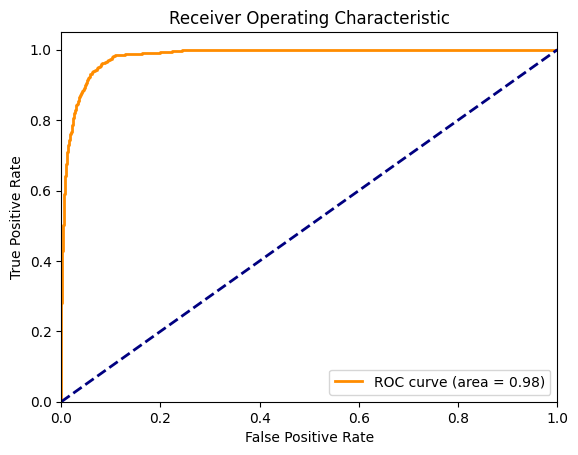

In [134]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation : Rankordering, KS statistic, Gini coeff

In [135]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

df_eval = pd.DataFrame({
    'Default Truth': y_test,
    'Default Probability': probabilities
})
df_eval.head(3)

,Default Truth,Default Probability
19205,0,0.53
15514,0,0.00
30367,0,0.00


In [136]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')
df_eval.head()

,Default Truth,Default Probability,Decile
19205,0,0.53,8
15514,0,0.00,2
30367,0,0.00,6
35347,0,0.01,6
41814,1,0.92,9


In [137]:
df_eval[df_eval.Decile==8]['Default Probability'].describe()

count   1250.00
mean       0.48
std        0.18
min        0.20
25%        0.31
50%        0.46
75%        0.63
max        0.82
Name: Default Probability, dtype: float64

In [138]:
df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum(),    
}))
df_decile.reset_index(inplace=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,0.00,0.00,0.00,1250.00
1,1,0.00,0.00,0.00,1250.00
2,2,0.00,0.00,0.00,1249.00
3,3,0.00,0.00,0.00,1250.00
4,4,0.00,0.00,0.00,1250.00
5,5,0.00,0.00,0.00,1249.00
6,6,0.00,0.03,4.00,1246.00
7,7,0.03,0.20,11.00,1238.00
8,8,0.20,0.82,156.00,1094.00
9,9,0.82,1.00,903.00,347.00


In [139]:
df_decile['Event Rate'] = df_decile['Events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,0,0.00,0.00,0.00,1250.00,0.00,100.00
1,1,0.00,0.00,0.00,1250.00,0.00,100.00
2,2,0.00,0.00,0.00,1249.00,0.00,100.00
3,3,0.00,0.00,0.00,1250.00,0.00,100.00
4,4,0.00,0.00,0.00,1250.00,0.00,100.00
5,5,0.00,0.00,0.00,1249.00,0.00,100.00
6,6,0.00,0.03,4.00,1246.00,0.32,99.68
7,7,0.03,0.20,11.00,1238.00,0.88,99.12
8,8,0.20,0.82,156.00,1094.00,12.48,87.52
9,9,0.82,1.00,903.00,347.00,72.24,27.76


In [140]:
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,0.82,1.00,903.00,347.00,72.24,27.76
1,8,0.20,0.82,156.00,1094.00,12.48,87.52
2,7,0.03,0.20,11.00,1238.00,0.88,99.12
3,6,0.00,0.03,4.00,1246.00,0.32,99.68
4,5,0.00,0.00,0.00,1249.00,0.00,100.00
5,4,0.00,0.00,0.00,1250.00,0.00,100.00
6,3,0.00,0.00,0.00,1250.00,0.00,100.00
7,2,0.00,0.00,0.00,1249.00,0.00,100.00
8,1,0.00,0.00,0.00,1250.00,0.00,100.00
9,0,0.00,0.00,0.00,1250.00,0.00,100.00


In [141]:
df_decile['Cum Events'] =  df_decile['Events'].cumsum()
df_decile['Cum Non-events'] =  df_decile['Non-events'].cumsum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events
0,9,0.82,1.00,903.00,347.00,72.24,27.76,903.00,347.00
1,8,0.20,0.82,156.00,1094.00,12.48,87.52,1059.00,1441.00
2,7,0.03,0.20,11.00,1238.00,0.88,99.12,1070.00,2679.00
3,6,0.00,0.03,4.00,1246.00,0.32,99.68,1074.00,3925.00
4,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00
5,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00
6,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00
7,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00
8,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00
9,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00


In [142]:
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events']*100 / df_decile['Non-events'].sum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,0.82,1.00,903.00,347.00,72.24,27.76,903.00,347.00,84.08,3.04
1,8,0.20,0.82,156.00,1094.00,12.48,87.52,1059.00,1441.00,98.60,12.61
2,7,0.03,0.20,11.00,1238.00,0.88,99.12,1070.00,2679.00,99.63,23.45
3,6,0.00,0.03,4.00,1246.00,0.32,99.68,1074.00,3925.00,100.00,34.36
4,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00,100.00,45.29
5,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00,100.00,56.24
6,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00,100.00,67.18
7,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00,100.00,78.11
8,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00,100.00,89.06
9,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00,100.00,100.00


In [143]:
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,0.82,1.00,903.00,347.00,72.24,27.76,903.00,347.00,84.08,3.04,81.04
1,8,0.20,0.82,156.00,1094.00,12.48,87.52,1059.00,1441.00,98.60,12.61,85.99
2,7,0.03,0.20,11.00,1238.00,0.88,99.12,1070.00,2679.00,99.63,23.45,76.17
3,6,0.00,0.03,4.00,1246.00,0.32,99.68,1074.00,3925.00,100.00,34.36,65.64
4,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00,100.00,45.29,54.71
5,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00,100.00,56.24,43.76
6,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00,100.00,67.18,32.82
7,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00,100.00,78.11,21.89
8,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00,100.00,89.06,10.94
9,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00,100.00,100.00,0.00


To assess whether rank ordering is followed, we should look at whether higher deciles (those with higher predicted probabilities) have higher event rates compared to lower deciles. Rank ordering means that as you move from the top decile to the bottom decile, the event rate should generally decrease.

Non-Events - termed as good (customers) who do not default. Events - termed as bad (customers) who default.

Events and Non-Events terms are interchanged based on usecase to usecase.

eg: for marketing usecase, which customer to reach out (who will take loan based on offers) will be events - here it will termed as good, and the customers who will not take loans will be non-events (bad).

**Insights from the Decile Table**

1. Top Deciles

* The first decile (Decile 9) has a high event rate of 72.00% and a non-event rate of 28.00%. This indicates that the model is highly confident in predicting events in this decile.
* The second decile (Decile 8) also shows a significant event rate of 12.72%, with a cumulative event rate reaching 98.6%.

2. Middle Deciles:

* Deciles 7 and 6 show a significant drop in event rates

3. Lower Deciles:

* Deciles 5 to 0 show zero events, with all predictions being non-events. These deciles collectively have a non-event rate of 100%.

4. KS Statistic:

* The KS statistic, which is the maximum difference between cumulative event rates and cumulative non-event rates, is highest at Decile 8 with a value of 85.98%. This suggests that the model performs best at distinguishing between events and non-events up to this decile.

* The KS value gradually decreases in the following deciles, indicating a decrease in model performance for distinguishing between events and non-events.

**KS Value**

The highest KS value is 85.98%, found at Decile 8. This indicates that the model's performance in distinguishing between events and non-events is most significant at this decile. (If KS is in top 3 decile and score above 40, it is considered a good predictive model.)

In [144]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.983665384174599
Gini Coefficient: 0.9673307683491981


AUC of 0.98: The model is very good at distinguishing between events and non-events.

Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

#### Finalize The Model and Visualize Feature Importance

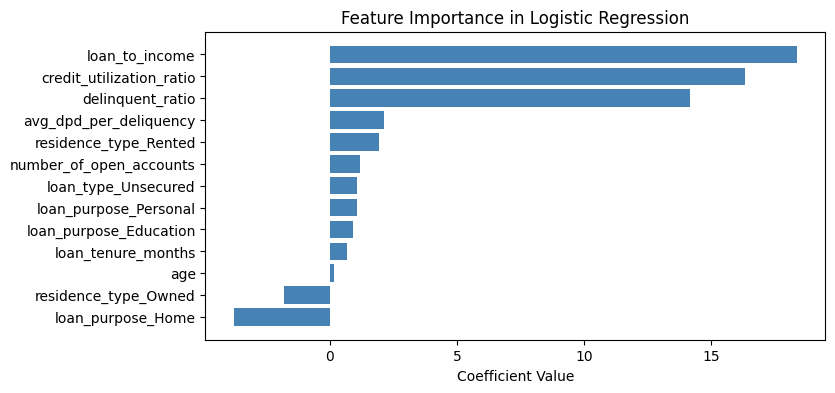

In [145]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Save the Model

In [146]:
X_test_encoded.head(2)

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquent_ratio,avg_dpd_per_deliquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.35,0.75,0.33,0.99,0.55,0.00,0.00,True,False,False,True,False,False
15514,0.48,0.23,1.00,0.32,0.22,0.00,0.00,True,False,True,False,False,False


In [147]:
X_test_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquent_ratio',
       'avg_dpd_per_deliquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [148]:
numeric_col

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquent_ratio',
       'avg_dpd_per_deliquency'],
      dtype='object')

In [149]:
X_train_encoded.head()

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquent_ratio,avg_dpd_per_deliquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
12746,0.79,0.42,1.00,0.36,0.42,0.13,0.59,True,False,False,True,False,False
32495,0.50,0.83,0.67,0.05,0.31,0.06,0.62,True,False,True,False,False,False
43675,0.38,0.49,0.00,0.00,0.76,0.22,0.56,False,False,False,True,False,False
9040,0.46,0.64,0.67,0.88,0.19,0.00,0.00,False,False,True,False,False,False
13077,0.77,0.17,0.00,0.72,0.05,0.00,0.00,True,False,False,False,True,True


In [150]:
X_train_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquent_ratio',
       'avg_dpd_per_deliquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [151]:
# model_data = {
#     'model': final_model,
#     'features': X_train_encoded.columns,
#     'scaler': scaler,
#     'cols_to_scale': numeric_col
# }
# dump(model_data, 'artifacts/model_data.joblib')

In [152]:
final_model.coef_, final_model.intercept_

(array([[ 0.16899137,  0.69045201,  1.1993271 , 16.3392397 , 18.37895353,
         14.16488873,  2.14159719, -1.80717641,  1.925899  ,  0.91938476,
         -3.77906533,  1.08928612,  1.08928612]]),
 array([-21.60300087]))